In [1]:
%matplotlib inline
import nest_asyncio
nest_asyncio.apply()

from mutabledataset import GermanSimDataset
from sklearn.preprocessing import MaxAbsScaler
from agent import RationalAgent
from simulation import Simulation
from learner import LogisticLearner
import plot
import numpy as np
import pandas as pd
from learner import StatisticalParityLogisticLearner, StatisticalParityFlipperLogisticLearner
from learner import FairLearnLearner
from learner import RandomForestLearner, MultinomialNBLearner
from learner import RejectOptionsLogisticLearner
from learner import ReweighingLogisticLearner
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal

sns.set()

## Parameters for simulation

In [2]:
mutable_attr = 'month'
group_attr = 'age'
priv_classes = [lambda x: x >= 25]

privileged_group = {group_attr: 1}
unprivileged_group = {group_attr: 0}

cost_fixed = lambda size: np.abs(np.random.normal(loc=0,scale=0.5,size=size))
# TODO: plot cost function for dataset

M = 0.2
L = 0.9
cp = lambda x_new, x: abs(x_new-x)

data = GermanSimDataset(mutable_features=[mutable_attr],
        domains={mutable_attr: 'auto'},
                     discrete=[mutable_attr],
                     protected_attribute_names=[group_attr],
                     cost_fns={mutable_attr: cp},
                     privileged_classes=priv_classes,
                     features_to_drop=['personal_status', 'sex', 'foreign_worker'])

## Common simulation code

In [3]:
def do_sim(learner, cost_fixed=cost_fixed, cost_fixed_dep=None, collect_incentive_data=False):
    sim = Simulation(data,
                     RationalAgent,
                     learner,
                     cost_fixed if cost_fixed_dep is None else None,
                     collect_incentive_data=collect_incentive_data,
                     avg_out_incentive=1,
                     no_neighbors=51,
                     cost_distribution_dep=cost_fixed_dep,
                     split=[0.9])

    result_set = sim.start_simulation(runs=1)
    return result_set

## Which feature?

In [4]:
l = LogisticLearner()
l.fit(data)
display(pd.DataFrame(columns=['Feature', 'Coefficient LogReg'], data=l.coefs))

,Feature,Coefficient LogReg
0,month,-2.167224
1,credit_amount,-1.663086
2,status=A14,1.110178
3,credit_history=A34,1.051038
4,other_debtors=A103,1.025873
5,purpose=A48,1.024730
6,purpose=A41,0.883851
7,purpose=A46,-0.801995
8,purpose=A410,0.742291
9,employment=A74,0.720118


## Cost function?

In [6]:
rs = do_sim(RandomForestLearner(exclude_protected=True), collect_incentive_data=True)
ax = sns.lineplot(x=mutable_attr, y="incentive",hue=group_attr,data=(rs.                      _avg_incentive(mutable_attr, group_attr)).reset_index())
#plt.savefig(name+".png")
plt.show()

(900, 51) (100, 51)
ERROR! Session/line number was not unique in database. History logging moved to new session 175


NameError: name 'rs' is not defined

738.0  before:  700.0


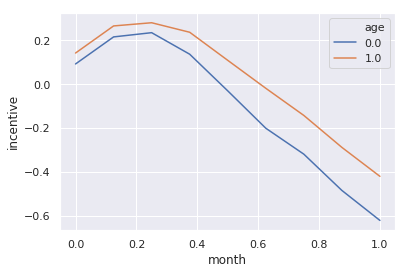

In [5]:
def merge_dfs(col, colval1, colval2, df1, df2):
    df1[col] = pd.Series([colval1] * len(df1.index), df1.index)
    df2[col] = pd.Series([colval2] * len(df2.index), df2.index)
    return pd.concat((df1, df2))
merged =merge_dfs('time', 'pre', 'post', rs.results[0].df, rs.results[0].df_new)
sns.catplot(x=mutable_attr, hue="time", kind="count",
            data=merged)
plt.show()

## Comparison of different predictive methods

(900, 51) (100, 51)
727.0  before:  700.0
(900, 51) (100, 51)
732.0  before:  700.0
(900, 51) (100, 51)
704.0  before:  700.0


<Figure size 432x288 with 0 Axes>

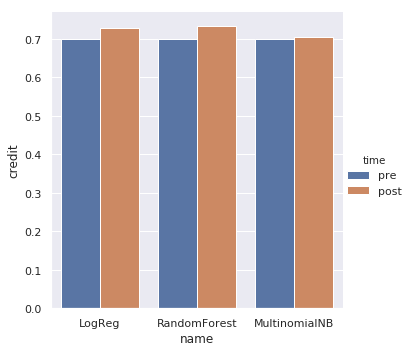

In [7]:
y_attr = 'credit' #mutable_attr # credit_h for prediction, credit for updated ground truth
def extract_avg_ft(rs, ft, name):
    pre_p_mean, _, post_p_mean, _ = rs.feature_average(y_attr, {})
    return [[name, 'pre', pre_p_mean], [name, 'post', post_p_mean]]
plot_data = []

rs = do_sim(LogisticLearner(exclude_protected=True))
plot_data = extract_avg_ft(rs, y_attr, "LogReg")

rs = do_sim(RandomForestLearner())
plot_data += extract_avg_ft(rs, y_attr, "RandomForest")

rs = do_sim(MultinomialNBLearner())
plot_data += extract_avg_ft(rs, y_attr, "MultinomialNB")

plot_data_df = pd.DataFrame(plot_data, columns=["name", "time", y_attr])
plt.figure()
sns.catplot(x="name", y=y_attr, hue="time", kind="bar",
            data=plot_data_df)
plt.show()



## Color-sighted vs. color-blind

(900, 51) (100, 51)
728.0  before:  700.0
(900, 51) (100, 51)
724.0  before:  700.0
(900, 51) (100, 51)
752.0  before:  700.0
(900, 51) (100, 51)
741.0  before:  700.0
(900, 51) (100, 51)
702.0  before:  700.0
(900, 51) (100, 51)
704.0  before:  700.0


<Figure size 432x288 with 0 Axes>

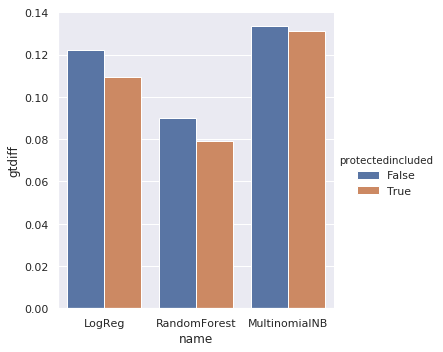

In [16]:

metric_name = "gtdiff" #gtdiff, mutablediff

def extract_metric(rs, metric_name="statpar"):
    if metric_name == "statpar":
        ret = rs.stat_parity_diff(unprivileged_group, privileged_group)
        return ret
    elif metric_name == 'gtdiff':
        gt_label = data.label_names[0]
        _, _, post_p_mean, _ = rs.feature_average(gt_label, privileged_group)
        _, _, post_up_mean, _ = rs.feature_average(gt_label, unprivileged_group)
        return abs(post_p_mean - post_up_mean)
    elif metric_name == 'mutablediff':
        _, _, post_p_mean, _ = rs.feature_average(mutable_attr, privileged_group)
        _, _, post_up_mean, _ = rs.feature_average(mutable_attr, unprivileged_group)
        return abs(post_p_mean - post_up_mean)

    return None


plot_data = []
rs = do_sim(LogisticLearner(exclude_protected=True))
plot_data.append(["LogReg", False, extract_metric(rs, metric_name=metric_name)])

rs = do_sim(LogisticLearner())
plot_data.append(["LogReg", True, extract_metric(rs, metric_name=metric_name)])

rs = do_sim(RandomForestLearner())
plot_data.append(["RandomForest", True, extract_metric(rs, metric_name=metric_name)])

rs = do_sim(RandomForestLearner(exclude_protected=True))
plot_data.append(["RandomForest", False, extract_metric(rs, metric_name=metric_name)])

rs = do_sim(MultinomialNBLearner())
plot_data.append(["MultinomialNB", True, extract_metric(rs, metric_name=metric_name)])

rs = do_sim(MultinomialNBLearner(exclude_protected=True))
plot_data.append(["MultinomialNB", False, extract_metric(rs, metric_name=metric_name)])

plot_data_df = pd.DataFrame(plot_data, columns=["name", "protectedincluded", metric_name])

plt.figure()
sns.catplot(x="name", y=metric_name, hue="protectedincluded", kind="bar",
            data=plot_data_df)
plt.savefig("sighted_comp.png")


## Notions of Fairness

(900, 51) (100, 51)
733.0  before:  700.0
(900, 51) (100, 51)
735.0  before:  700.0


<Figure size 432x288 with 0 Axes>

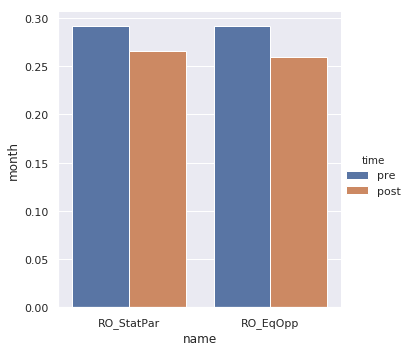

In [12]:

# Compare different notions of fairness
y_attr = mutable_attr

rs = do_sim(RejectOptionsLogisticLearner([privileged_group], [unprivileged_group]))
plot_data = extract_avg_ft(rs, mutable_attr, "RO_StatPar")

rs = do_sim(RejectOptionsLogisticLearner([privileged_group], [unprivileged_group], metric_name='Equal opportunity difference'))
plot_data += extract_avg_ft(rs, mutable_attr, "RO_EqOpp")

plot_data_df = pd.DataFrame(plot_data, columns=["name", "time", y_attr])


plt.figure()
sns.catplot(x="name", y=y_attr, hue="time", kind="bar",
            data=plot_data_df)
plt.show()


## Statistical parity comparison

(900, 51) (100, 51)
731.0  before:  700.0
(900, 51) (100, 51)
722.0  before:  700.0
(900, 51) (100, 51)
730.0  before:  700.0


<Figure size 432x288 with 0 Axes>

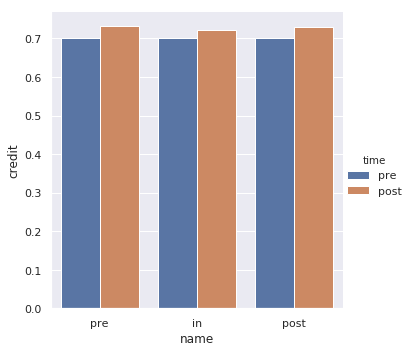

In [17]:

plot_data = []
learners = [("pre", ReweighingLogisticLearner([privileged_group], [unprivileged_group])),
    ("in",FairLearnLearner([privileged_group], [unprivileged_group])),
    ("post",RejectOptionsLogisticLearner([privileged_group], [unprivileged_group]))]

y_attr = mutable_attr
y_attr = 'credit'

for name, l in learners:
    rs = do_sim(l)
    plot_data += extract_avg_ft(rs, mutable_attr, name)

plot_data_df = pd.DataFrame(plot_data, columns=["name", "time", y_attr])

plt.figure()
sns.catplot(x="name", y=y_attr, hue="time", kind="bar",
            data=plot_data_df)
plt.show()

# split for groups
# 1. section 2.1 for cost function
# 2. cost function as distance, only within group (immutable)

## Time of Intervention

(900, 51) (100, 51)
726.0  before:  700.0
(900, 51) (100, 51)
722.0  before:  700.0
(900, 51) (100, 51)
727.0  before:  700.0
(900, 51) (100, 51)
730.0  before:  700.0
(900, 51) (100, 51)
700.0  before:  700.0
(900, 51) (100, 51)
736.0  before:  700.0
(900, 51) (100, 51)
736.0  before:  700.0
(900, 51) (100, 51)
743.0  before:  700.0
  index   subsidy  mutablediff
0   pre  0.000000     0.018508
1   pre  0.333333     0.030337
2   pre  0.666667     0.026496
3   pre  1.000000     0.038828
4  post  0.000000     0.006438
5  post  0.333333     0.012678
6  post  0.666667     0.020039
7  post  1.000000     0.015864


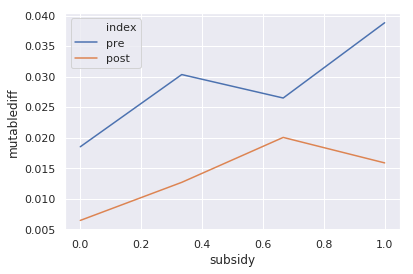

In [15]:

metric_name = 'mutablediff' # statpar, gtdiff
subsidies = np.linspace(0,1,4)
learner = LogisticLearner(exclude_protected=True)

# creates a instance dependant cost lambda fn
# which reduces cost for unprivileged group by subsidy
def cost_fixed_dependant(subsidy):
    group_attr_ind = data._ft_index(group_attr)
    privileged_val = privileged_group[group_attr]

    return lambda x: cost_fixed(1)[0] if x[group_attr_ind] == privileged_val else cost_fixed(1)[0] - subsidy

result_sets = list(map(lambda s: do_sim(learner, cost_fixed_dep=cost_fixed_dependant(s)), subsidies))
result_sets += list(map(lambda s: do_sim(RejectOptionsLogisticLearner([privileged_group], [unprivileged_group], abs_bound=s)), subsidies))

y_values = list(map(lambda rs: extract_metric(rs, metric_name), result_sets))
index = ['pre'] * len(subsidies) + ['post'] * len(subsidies)
x = np.array([np.hstack((subsidies,subsidies)), y_values]).transpose()

plot_data_df = pd.DataFrame(x, columns=['subsidy', metric_name],index=index).reset_index()
print(plot_data_df)
plt.figure()
ax = sns.lineplot(x='subsidy',hue='index', y=metric_name, data=plot_data_df)
plt.show()

#for rs in result_sets:
#    ax = sns.lineplot(x=mutable_attr, y="incentive",hue=group_attr,data=(rs.                     _avg_incentive(mutable_attr, group_attr)).reset_index())
#    plt.show()